# Exercise 5: Scene-Dependent Image Segmentation

The goal of this homework is to implement a model that seperates foreground and background objects for a specific scene.  
We will use the highway scene from the Change Detection dataset:  
http://jacarini.dinf.usherbrooke.ca/dataset2014#

![input image](highway/input/in001600.jpg "Title") ![gt image](highway/groundtruth/gt001600.png "Title")

## Task 1: Create a custom (Pytorch) dataset


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
You need to create a class that inherets from **from torch.utils.data.Dataset** and implements two methods:
- **def \_\_len\_\_(self)**:  returns the length of the dataset
- **def \_\_getitem\_\_(self, idx)**: given an integer idx returns the data x,y
    - x is the image as a float tensor of shape: $(3,H,W)$ 
    - y is the label image as a mask of shape: $(H,W)$ each pixel should contain the label 0 (background) or 1 (foreground). It is recommended to use the type torch.long
    
**Tips**:
- The first 470 images are not labeled. Just ignore these images. 
- If possible load all images into memory or even directly to GPU to increase speed.
- You can change the resolution to fit your model or your memory
- Add data augmentation to increase the data size and model robustness

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score
import matplotlib.pyplot as plt

import glob
from PIL import Image
import gdown
import os

In [2]:
class ChangeDetectionDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        if not transform:
            self.transform = transforms.Compose([
                transforms.Resize((240, 240)),
                transforms.ToTensor()
            ])
        
        self.imgs = sorted(glob.glob(root_dir + "input/*.jpg"))
        self.imgs = [self.transform(Image.open(img)) for img in self.imgs]
        self.gts = sorted(glob.glob(root_dir + "groundtruth/*.png"))
        self.gts = [(self.transform(Image.open(gt)) > 0).squeeze(dim=0).long() for gt in self.gts]

    def __getitem__(self, idx):
        img = self.imgs[idx]
        gt = self.gts[idx]
        return img, gt
    
    def __len__(self):
        return len(self.imgs)

## Task 2: Create a custom Segmentation Model

- input: a batch of images $(B,3,H,W)$ 
- output: a batch of pixel-wise class predictions $(B,C,H,W)$, where $C=2$

Tips:
- It is recommended to use a Fully-Convolutional Neural Network, because it flexible to the input and output resolution.
- Use Residual Blocks with convolutional layers.
- Base your model on established segmentation models:
    - U-Net: https://arxiv.org/abs/1505.04597
    - Deeplab: https://arxiv.org/abs/1606.00915

In [4]:
# load dataset
root_dir = "highway/"
complete_dataset = ChangeDetectionDataset(root_dir)
# split dataset (80/20)
generator = torch.Generator().manual_seed(42)
X_train, X_test = random_split(complete_dataset, [0.8, 0.2], generator=generator)
len(X_train), len(X_test)

(985, 246)

In [5]:
class ConvLayer(nn.Module):

    def __init__(self, 
        in_channels, 
        out_channels, 
        kernel_size=3,
        stride=1,
        padding=0,
        batch_norm=False
    ):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size,
            stride=stride, 
            padding=padding
        )
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(self.conv(x)) if self.bn else self.conv(x)
        x = self.relu(x)
        return x

def createConvSequential(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=1,
    padding=1,
    batch_norm=True
):
    conv_sequential = nn.Sequential(
        ConvLayer(in_channels, out_channels, kernel_size, stride, padding, batch_norm),
        ConvLayer(out_channels, out_channels, kernel_size, stride, padding, batch_norm)
    )
    return conv_sequential

In [6]:
class UNet(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # used channels
        self.ch1 = 64
        self.ch2 = 128
        self.ch3 = 256
        self.ch4 = 512
        self.ch5 = 1024
        # downsampling conv-layers
        self.ds1 = createConvSequential(self.in_channels, self.ch1)
        self.ds2 = createConvSequential(self.ch1, self.ch2)
        self.ds3 = createConvSequential(self.ch2, self.ch3)
        self.ds4 = createConvSequential(self.ch3, self.ch4)
        # bottleneck
        self.ds5 = createConvSequential(self.ch4, self.ch5)
        # upsampling conv-layers
        self.us1 = createConvSequential(self.ch5, self.ch4)
        self.us2 = createConvSequential(self.ch4, self.ch3)
        self.us3 = createConvSequential(self.ch3, self.ch2)
        self.us4 = createConvSequential(self.ch2, self.ch1)
        # modules for chanaging channel sizes
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.trans_conv1 = nn.ConvTranspose2d(self.ch5, self.ch4, kernel_size=2, stride=2)
        self.trans_conv2 = nn.ConvTranspose2d(self.ch4, self.ch3, kernel_size=2, stride=2)
        self.trans_conv3 = nn.ConvTranspose2d(self.ch3, self.ch2, kernel_size=2, stride=2)
        self.trans_conv4 = nn.ConvTranspose2d(self.ch2, self.ch1, kernel_size=2, stride=2)
        self.last_conv = nn.Conv2d(self.ch1, self.num_classes, kernel_size=1) # creates fore- and background masks
    
    def forward(self, x):
        
        # downsampling path
        ds_res1 = self.ds1(x)
        x = self.max_pool(ds_res1)

        ds_res2 = self.ds2(x)
        x = self.max_pool(ds_res2)

        ds_res3 = self.ds3(x)
        x = self.max_pool(ds_res3)

        ds_res4 = self.ds4(x)
        x = self.max_pool(ds_res4)

        # bottleneck
        x = self.ds5(x)

        # upsampling path
        x = self.trans_conv1(x)
        x = torch.concatenate((ds_res4, x), dim=1)
        x = self.us1(x)

        x = self.trans_conv2(x)
        x = torch.concatenate((ds_res3, x), dim=1)
        x = self.us2(x)

        x = self.trans_conv3(x)
        x = torch.concatenate((ds_res2, x), dim=1)
        x = self.us3(x)

        x = self.trans_conv4(x)
        x = torch.concatenate((ds_res1, x), dim=1)
        x = self.us4(x)
        
        x = self.last_conv(x)
        return x

## Task 3: Create a training loop
- split data into training and test data, e.g. 80% training data and 20% test data using your custom dataset.
- Create a Dataloader for your custom datasets 
- Define a training loop for a single epoch:
    - forward pass
    - Loss function, e.g. cross entropy
    - optimizer 
    - backward pass
    - logging
- Define validation loop:
    - forward pass
    - extract binary labels, e.g. threshold or argmax for each pixel.
    - compute evaluation metrics: Accuracy, Precision, Recall and Intersection over Union for each image

In [7]:
def train_model(
    model, 
    device,
    train_loader,
    test_loader,
    train_func,
    test_func,
    lr=0.001, 
    step_size=10, 
    gamma=0.1, 
    epochs=10,
    **additional_params
):
    train_params = additional_params.pop("train_params", {})
    test_params = additional_params.pop("test_params", {})
    
    train_losses, test_losses = [], []
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    for epoch in range(1, epochs + 1):
        train_loss = train_func(model, device, train_loader, optimizer, epoch, **train_params)
        test_loss = test_func(model, device, test_loader, epoch, **test_params)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()

    return train_losses, test_losses

In [8]:
def train_segmentation_model(
    model, 
    device, 
    train_loader, 
    optimizer, 
    epoch
):
    model.train()
    train_loss = 0.
    total_pixel = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # load images and masks to gpu
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.cross_entropy(output, target, reduction="sum").item()
        total_pixel += target.numel()

        if batch_idx % 10 == 0:
            data_processed_so_far = batch_idx * len(data)
            total_data = len(train_loader.dataset)
            progress = 100. * batch_idx / len(train_loader)
            
            print("Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, data_processed_so_far, total_data, progress, loss.item()
            ), end="\r")
            
    train_loss /= total_pixel
    return train_loss


def test_segmentation_model(
    model, 
    device, 
    test_loader, 
    epoch
):
    model.eval()
    all_targets = []
    all_preds = []
    test_loss = 0.
    total_pixel = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            # process target and predicition
            pred = output.argmax(dim=1)
            test_loss += F.cross_entropy(output, target, reduction="sum").item()
            total_pixel += target.numel()
            all_targets.append(target.flatten().cpu())
            all_preds.append(pred.flatten().cpu())

    # compute accuracy, precision, recall, IoU
    test_loss /= total_pixel
    y_true = torch.cat(all_targets)
    y_pred = torch.cat(all_preds)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    IoU = jaccard_score(y_true, y_pred, zero_division=0)

    print("Test Set (Epoch {}): Avg. Test-Loss: {:.2f}\tAccuracy: {:.2f}\tPrecision: {:.2f}\tRecall: {:.2f}\tIoU: {:.2f}".format(
        epoch, test_loss, accuracy, precision, recall, IoU, 80 * " "
    ))
    return test_loss

In [27]:
# IF FLAG IS SET, LOAD PRE-TRAINED MODEL FROM THE CLOUD
load_pre_trained_unet_from_cloud = True

# hyperparameters
batch_size = 32
in_channels = 3
num_classes = 2
step_size = 5
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create training and train loader
train_loader = DataLoader(X_train, batch_size=batch_size)
test_loader = DataLoader(X_test, batch_size=batch_size)

In [ ]:
# run training (if flag not set)
if not load_pre_trained_unet_from_cloud:
    print(f"Training is running with: {device}")
    unet_model = UNet(in_channels, num_classes).to(device)
    train_losses, test_losses = train_model(
        unet_model,
        device,
        train_loader,
        test_loader,
        train_segmentation_model,
        test_segmentation_model,
        step_size=step_size,
        epochs=epochs
    )

Training is running with: cuda
Test Set (Epoch 1): Avg. Test-Loss: 0.22	Accuracy: 0.93	Precision: 1.00	Recall: 0.16	IoU: 0.16
Test Set (Epoch 2): Avg. Test-Loss: 0.30	Accuracy: 0.89	Precision: 0.43	Recall: 0.98	IoU: 0.42
Test Set (Epoch 3): Avg. Test-Loss: 0.03	Accuracy: 0.99	Precision: 0.99	Recall: 0.93	IoU: 0.92
Test Set (Epoch 4): Avg. Test-Loss: 0.02	Accuracy: 1.00	Precision: 0.99	Recall: 0.95	IoU: 0.94
Test Set (Epoch 5): Avg. Test-Loss: 0.03	Accuracy: 0.99	Precision: 0.92	Recall: 0.97	IoU: 0.90
Test Set (Epoch 6): Avg. Test-Loss: 0.02	Accuracy: 1.00	Precision: 0.98	Recall: 0.97	IoU: 0.95
Test Set (Epoch 7): Avg. Test-Loss: 0.02	Accuracy: 1.00	Precision: 0.98	Recall: 0.97	IoU: 0.95
Test Set (Epoch 8): Avg. Test-Loss: 0.02	Accuracy: 1.00	Precision: 0.98	Recall: 0.97	IoU: 0.96
Test Set (Epoch 9): Avg. Test-Loss: 0.02	Accuracy: 1.00	Precision: 0.98	Recall: 0.97	IoU: 0.96
Test Set (Epoch 10): Avg. Test-Loss: 0.01	Accuracy: 1.00	Precision: 0.98	Recall: 0.97	IoU: 0.96


In [28]:
# save model (if flag not set)
model_path = "models/unet_model.pth"
if not load_pre_trained_unet_from_cloud:
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(unet_model.state_dict(), model_path)

## Task 4: Small Report of your model and training
- visualize training and test error over each epoch
- report the evaluation metrics of the final model

In [ ]:
# (download and) load model 
trained_unet = UNet(in_channels, num_classes)
if load_pre_trained_unet_from_cloud and not os.path.exists(model_path):
    model_url = "https://drive.google.com/drive/folders/1s_vETe9HEFHvSkT4hwRZh34_dHgBclBz?usp=sharing"
    gdown.download_folder(model_url, quiet=True)

trained_unet.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
trained_unet.eval()

UNet(
  (ds1): Sequential(
    (0): ConvLayer(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (ds2): Sequential(
    (0): ConvLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ConvLayer(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (ds3): Sequent

In [34]:
def plot_comparision(gt, pred):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(gt, cmap="gray")
    plt.axis("off")
    plt.title("Ground Truth")
    plt.subplot(1, 2, 2)
    plt.imshow(pred, cmap="gray")
    plt.axis("off")
    plt.title("Predicted Mask")

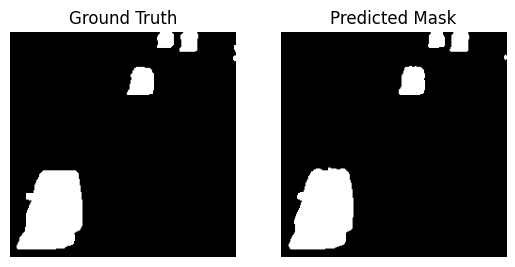

In [35]:
idx = 0
imgs, gts = next(iter(test_loader)) # get first batch
img, gt = imgs[idx].unsqueeze(dim=0), (gts[idx] > 0).squeeze(dim=0).long()
output = trained_unet(img).argmax(dim=1).squeeze(dim=0)
plot_comparision(gt, output)

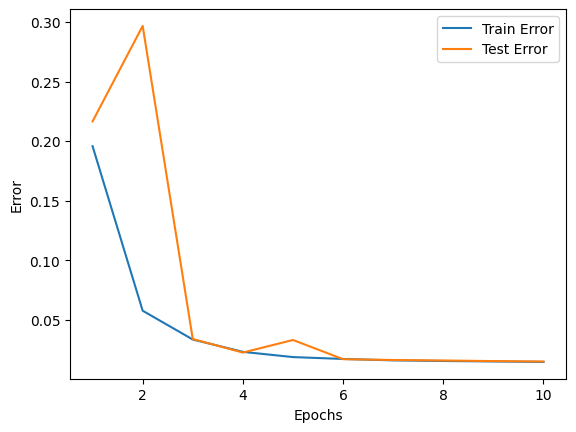

In [31]:
epochs = 10
x = torch.arange(1, epochs + 1)

plt.plot(x, train_losses, label="Train Error")
plt.plot(x, test_losses, label="Test Error")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

In [36]:
final_test = test_segmentation_model(trained_unet.to(device), device, test_loader, "-")

Test Set (Epoch -): Avg. Test-Loss: 0.01	Accuracy: 1.00	Precision: 0.98	Recall: 0.97	IoU: 0.96


### Conclusion:
As the results show the model converges and attains high accuracy as well as solid IoU.